Import a lot of modules. Many of them are not really needed, but why to reinvent the wheel? All of them can be installed with `pip install` or `python-pip install`

In [178]:
import mailbox                                      # to read mbox (and others) format
from email_reply_parser import EmailReplyParser     # to split reply for the main message, see https://github.com/zapier/email-reply-parser
from collections import Counter                     # to accumulate, probably there are better solution based on real histograms
import email
from string import maketrans
from datetime import datetime
import calendar
import logging
logging.basicConfig(level=logging.INFO)
import re
from math import log, exp, sqrt
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer   # to parse text, it can do much more
import pandas as pd                                           # to make tables
#pd.core.format.set_option('notebook_repr_html', True)     # in HTML
from IPython.display import display_pretty, display_html, display_jpeg, display_png, display_json, display_latex, display_svg

In [119]:
stopwords = STOPWORDS.copy()
mystopwords = 'type 01 02 just 20 00 02c3 a8 utf alla del po 40miinfnit 2eit 40mi tra alle 3e 3a 2c questo ve al f2 gli su cosa quello nel pi ti sia e2 anche ec lo don anche com http https e1 ch sono ma ci se e8 e0 ruggero turra saluti cheers da salve una un le ho ciao hello hi non di che la plain text ha new mi 24 content il 2014 jan wed charset all six less being indeed over move anyway four not own through yourselves fify where mill only find before one whose system how somewhere with thick show had enough should to must whom seeming under ours has might thereafter latterly do them his around than get very de none cannot every whether they front during thus now him nor name several hereafter always who cry whither this someone either each become thereupon sometime side two therein twelve because often ten our eg some back up go namely towards are further beyond ourselves yet out even will what still for bottom mine since please forty per its everything behind un above between it neither seemed ever across she somehow be we full never sixty however here otherwise were whereupon nowhere although found alone re along fifteen by both about last would anything via many could thence put against keep etc amount became ltd hence onto or con among already co afterwards formerly within seems into others while whatever except down hers everyone done least another whoever moreover couldnt throughout anyhow yourself three from her few together top there due been next anyone eleven much call therefore interest then thru themselves hundred was sincere empty more himself elsewhere mostly on fire am becoming hereby amongst else part everywhere too herself former those he me myself made twenty these bill cant us until besides nevertheless below anywhere nine can of your toward my something and whereafter whenever give almost wherever is describe beforehand herein an as itself at have in seem whence ie any fill again hasnt inc thereby thin no perhaps latter meanwhile when detail same wherein beside also that other take which becomes you if nobody see though may after upon most hereupon eight but serious nothing such why a off whereby third i whole noone sometimes well amoungst yours their rather without so five the first whereas once'
for m in mystopwords.split():
    stopwords.add(m)

The next step is to download the whole gmail emails, it can be done here: https://www.google.com/settings/takeout. By the way this code works with any `mbox` file

In [2]:
my_identities = [x.encode('rot13') for x in 'ehttreb.gheen@zv.vasa.vg', 'tvheereb@tznvy.pbz', 'ehttreb.gheen@prea.pu', 'e.gheen@prea.pu', 'egheen@prea.pu', 'Ehttreb Gheen']

In [3]:
# very slow
mbox = mailbox.mbox('/home/turra/Posta inviata.mbox')
len(mbox)

64099

In [4]:
stop_after = 0 # number of email to read. Set to 0 if you want to read all the emails
year = 2016      # year to read, skip the others. Set to 0 if you want to read all the years
box_name = "Posta inviata"

recipients_name = Counter()
recipients_email = Counter()
sent_hour = Counter(dict(zip(range(24), [0] * 24)))
sent_day = Counter(dict(zip(range(1, 7), [0] * 7)))
sent_month = Counter(dict(zip(range(1, 12), [0] * 11)))
len_replies = Counter()
words_count = Counter()

trantab = maketrans('\t\r\n', '   ')
r1 = re.compile(r'Il (giorno )?[0-9].*?@.*?scritto=?:', re.MULTILINE|re.DOTALL)
r7 = re.compile(r'On [0-9].*?@.*?wrote=?:', re.MULTILINE|re.DOTALL)
r2 = re.compile(r'From nobody.*?\n', re.DOTALL)
r3 = re.compile('Content-Type.*?$')
r4 = re.compile(r'[0-9].*?\@.*?:')
r5 = re.compile(r'\=[0-9]+[A-Z]')
r6 = re.compile(r' [0-9]+ ')

to_remove = ('Content-Disposition: inline',
             'Content-Type: text/plain; charset=ISO-8859-1',
             'Content-Type: text/plain; charset=windows-1252',
             'Content-Transfer-Encoding: quoted-printable',
             '.cern.ch')
cv = CountVectorizer(min_df=0, stop_words=stopwords, max_features=500)

for i, message in enumerate(tqdm(mbox)):
    try:
        if not message.has_key('X-Gmail-Labels'):
            continue
        if "Chat" in message['X-Gmail-Labels']:
            continue
        if box_name in message['X-Gmail-Labels']:
            To = message['To']       
            From = message['From']
            if not From:
                continue
            if not any(my_id in From for my_id in my_identities):
                continue
            date = datetime(*(email.utils.parsedate(message['date'])[:7]))
            if year and date.year != year:
                continue
            sent_hour.update({date.hour: 1})
            sent_day.update({date.isoweekday(): 1})
            sent_month.update({date.month: 1})

            if To:
                tos = [x.translate(trantab).strip() for x in To.split(',')]       
                to_parsed = email.utils.getaddresses(tos)
                for to in to_parsed:
                    recipients_name.update({to[0].lower(): 1})
                    recipients_email.update({to[1].lower(): 1})

            if message.is_multipart():           
                payload = str(message.get_payload()[0])
            else:
                payload = message.get_payload()

            erp = EmailReplyParser.read(payload)
            fragments = erp.fragments
            len_replies.update({len(fragments): 1})
            my_message = fragments[0].content

            my_message = reduce(lambda x, y: x.replace(y, ' '), to_remove, my_message)
            my_message = reduce(lambda y, x: x.sub('', y), (r1, r2, r3, r4, r5, r6, r7), my_message)
            my_message = my_message.strip()               

            if len(my_message):
                try:
                    counts = cv.fit_transform([my_message]).toarray().ravel()
                    words = np.array(cv.get_feature_names())
                    words_count.update(dict(zip(words, counts)))
                except:
                    logging.error('Cannot parse: "%s"', my_message)
            #print my_message
    except:
        print "problem with message"
        print message
        raise
    if stop_after and i > stop_after:
        break

  2%|▏         | 1040/64099 [00:06<08:06, 129.63it/s]ERROR:root:Cannot parse: "Content-Type: text/plain; charset=UTF-8"
ERROR:root:Cannot parse: "Content-Type: text/plain; charset=UTF-8"
  3%|▎         | 1779/64099 [00:13<06:28, 160.42it/s]ERROR:root:Cannot parse: "Content-Type: text/plain; charset=UTF-8"
ERROR:root:Cannot parse: "Content-Type: text/plain; charset=UTF-8"
  3%|▎         | 1951/64099 [00:13<04:24, 234.66it/s]ERROR:root:Cannot parse: "Content-Type: text/plain; charset=UTF-8"
ERROR:root:Cannot parse: "Content-Type: text/plain; charset=UTF-8"
  3%|▎         | 2149/64099 [00:14<04:21, 236.77it/s]ERROR:root:Cannot parse: "Content-Type: text/plain; charset=UTF-8
 

Go"
  5%|▍         | 3159/64099 [00:23<06:57, 146.07it/s]ERROR:root:Cannot parse: "Content-Type: text/plain; charset=UTF-8"
ERROR:root:Cannot parse: "Content-Type: text/plain; charset=UTF-8"
 88%|████████▊ | 56686/64099 [04:13<01:15, 97.56it/s] ERROR:root:Cannot parse: "Content-Type: text/plain; charset=UTF-8"
ERROR

In [5]:
sent_hour = pd.DataFrame.from_dict(sent_hour, orient="index")
sent_hour.columns = ['#emails']
sent_day = pd.DataFrame.from_dict(sent_day, orient="index")
sent_day.columns = ['#emails']
sent_month = pd.DataFrame.from_dict(sent_month, orient="index")
sent_month.columns = ['#emails']
len_replies = pd.DataFrame.from_dict(len_replies, orient="index")
len_replies.columns = ['#emails']

In [6]:
sent_hour

,#emails
0,62
1,33
2,22
3,5
4,0
5,0
6,0
7,5
8,75
9,170


In [7]:
sent_day

,#emails
1,575
2,619
3,618
4,535
5,471
6,90
7,104


In [8]:
sent_month

,#emails
1,179
2,304
3,238
4,244
5,308
6,403
7,270
8,69
9,118
10,379


In [9]:
len_replies

,#emails
1,492
2,27
3,899
4,19
5,203
6,60
7,175
8,31
9,149
10,7


In [10]:
sent_hour.plot(kind='bar', figsize=(14, 6))
sent_day.plot(kind='bar', figsize=(14, 6))
sent_month.plot(kind='bar', figsize=(14, 6))
len_replies.plot(figsize=(14, 6), xlim=(0, 50))

In [11]:
for x, y in words_count.most_common(300):
    print "%s: %d" % (x, y)

2016: 332
slide: 317
know: 294
00: 291
think: 288
thank: 282
data: 253
calibration: 245
ok: 242
02: 231
pdf: 229
want: 227
cern: 225
use: 225
plots: 224
christos: 221
gmt: 212
using: 210
atlas: 207
just: 206
root: 194
plot: 191
mc: 185
note: 178
event: 178
anastopoulos: 174
01: 162
scale: 159
need: 157
different: 156
sorry: 146
energy: 143
probably: 141
systematics: 141
eta: 140
20: 140
yes: 139
meeting: 139
time: 136
add: 136
mass: 135
error: 135
check: 135
sure: 134
look: 130
like: 128
xaod: 127
way: 125
used: 125
maybe: 125
signal: 124
twiki: 124
point: 123
problem: 122
tool: 122
let: 121
events: 117
guillaume: 116
bin: 115
study: 113
guess: 112
simone: 112
10: 112
pt: 112
example: 110
egamma: 109
std: 109
run: 109
resolution: 108
java: 108
number: 107
analysis: 107
2015: 106
indico: 106
test: 105
code: 103
ac: 102
background: 102
categories: 101
systematic: 98
a0: 98
char: 98
region: 98
model: 98
infn: 97
sample: 93
correction: 91
ask: 91
selection: 91
thibault: 90
cds: 89
higgs: 8

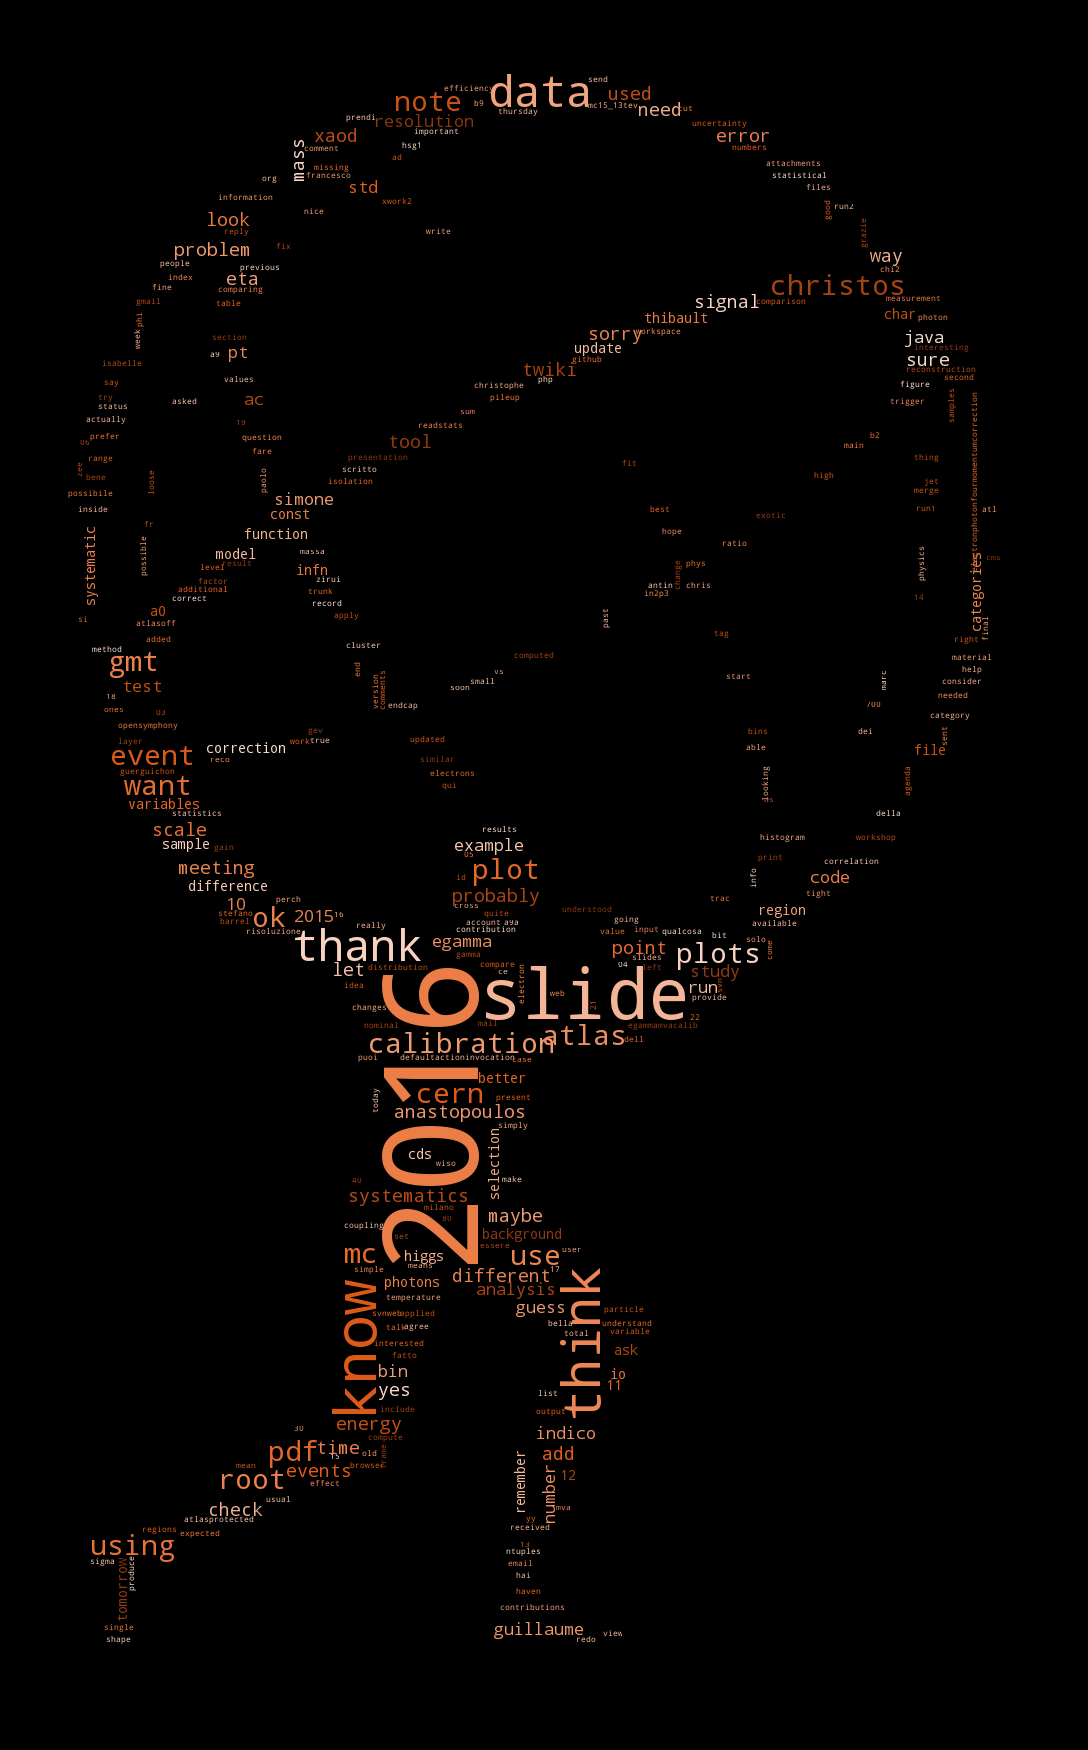

In [218]:
from scipy.misc import imread
import random

def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(20, 80%%, %d%%)" % random.randint(30, 90)

mask = imread("/home/turra/2016_2.png")
col = imread("/home/turra/2016_col.png")
image_colors = ImageColorGenerator(col)

freq = [(a, (float(b) / words_count.most_common(1)[0][1]) **2) for a, b in words_count.most_common(700) if a not in stopwords]
wordcloud = WordCloud(width=800, height=1080, max_words=700, scale=2,
                      background_color="black", mask=mask, stopwords=stopwords).generate_from_frequencies(freq)
wordcloud.recolor(color_func=grey_color_func, random_state=3)
#wordcloud.recolor(color_func=image_colors)
wordcloud.to_image()

In [219]:
wordcloud.to_file('temp.png')

In [188]:
del(wordcloud)